## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=cacf5e98a6f8290ae6f78484750f1ecc050688e8c7c03ed637291c593f9af974
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=e69d3bdcf6ff417ecb407a61b6578d0acffcf3b677eadb8679b227ac4a8ac757
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
import segmentation_models_pytorch as smp

In [5]:
!pip install warmup_scheduler

  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2983 sha256=dce5cf543bf1f6d4a5f5545f0206c60c273ace994a4353aac164c1cb6da4140f
  Stored in directory: /root/.cache/pip/wheels/66/42/8a/00cdef6e5a066e48a92c24051fdcdd57d87faa24c9b5f44a02
Successfully built warmup_scheduler


In [6]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [7]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'/kaggle/working/outputs/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [10]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [11]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [12]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [13]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [14]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [15]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [17]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [18]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [19]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

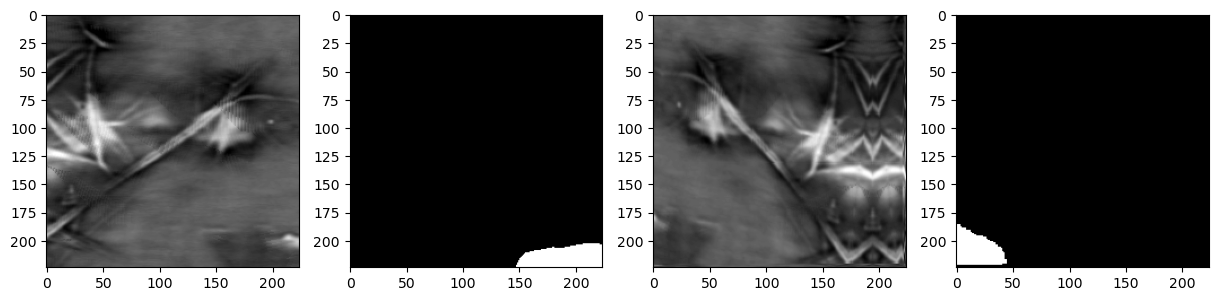

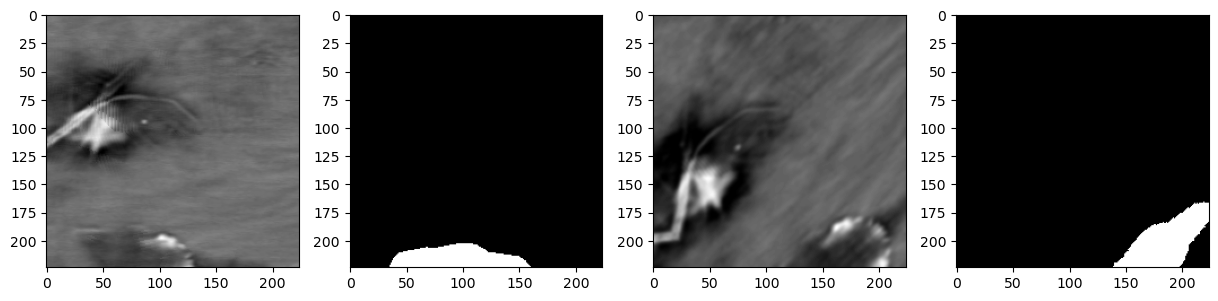

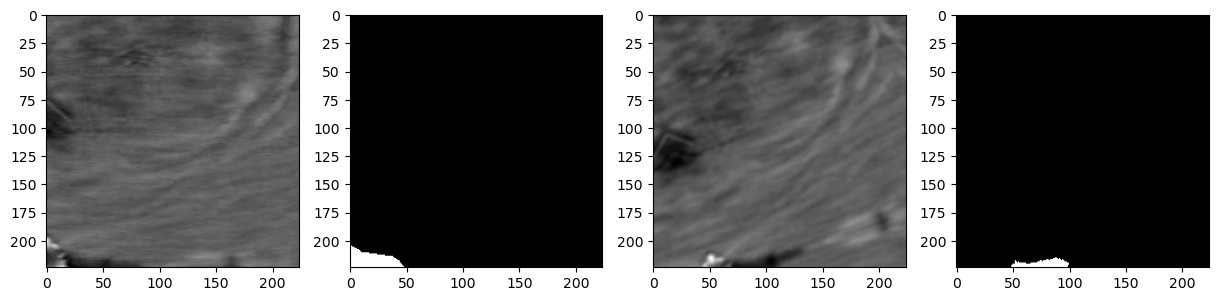

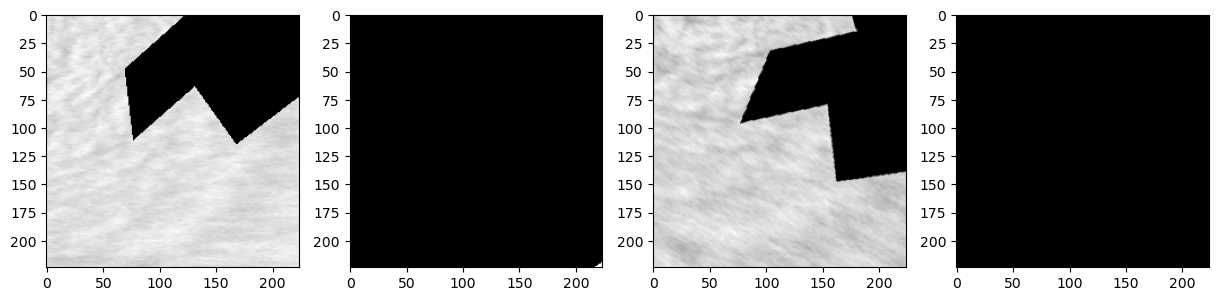

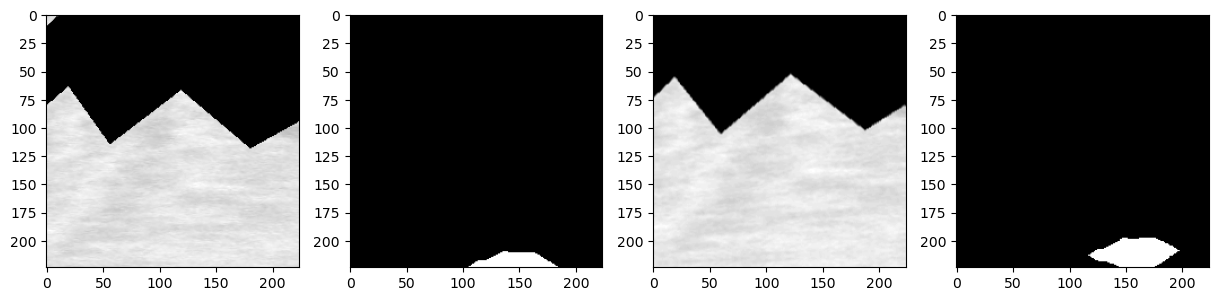

In [21]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [22]:
del plot_dataset
gc.collect()

48095

## model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [24]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [25]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

## loss

In [26]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [27]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [28]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [29]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [30]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096138841604875
th: 0.15, fbeta: 0.12092061093076302
th: 0.2, fbeta: 0.12218512134019265
th: 0.25, fbeta: 0.20849148386683702
th: 0.3, fbeta: 0.22698654496883916
th: 0.35, fbeta: 0.23553111991154413
th: 0.4, fbeta: 0.2298313269084883
th: 0.45, fbeta: 0.2021677594120987


best_th: 0.35, fbeta: 0.23553111991154413
Epoch 1 - avg_train_loss: 0.6189  avg_val_loss: 0.4177  time: 240s
Epoch 1 - avgScore: 0.2355
Epoch 1 - Save Best Score: 0.2355 Model
Epoch 1 - Save Best Loss: 0.4177 Model


th: 0.5, fbeta: 0.13694467806093338


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12153045797352263
th: 0.15, fbeta: 0.21594491016039644
th: 0.2, fbeta: 0.25197633744658166
th: 0.25, fbeta: 0.3016232827417063
th: 0.3, fbeta: 0.34941129825334083
th: 0.35, fbeta: 0.3786307262917063
th: 0.4, fbeta: 0.37466682949862457
th: 0.45, fbeta: 0.30478330255016073


best_th: 0.35, fbeta: 0.3786307262917063
Epoch 2 - avg_train_loss: 0.3914  avg_val_loss: 0.3225  time: 240s
Epoch 2 - avgScore: 0.3786
Epoch 2 - Save Best Score: 0.3786 Model
Epoch 2 - Save Best Loss: 0.3225 Model


th: 0.5, fbeta: 0.169659687228914


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:808: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.31398626204451546
th: 0.15, fbeta: 0.3592084967545608
th: 0.2, fbeta: 0.39442814170432483
th: 0.25, fbeta: 0.42110845988417617
th: 0.3, fbeta: 0.4277326920597959
th: 0.35, fbeta: 0.3800549203002161
th: 0.4, fbeta: 0.2504588117891854
th: 0.45, fbeta: 0.0914047732890349


best_th: 0.3, fbeta: 0.4277326920597959
Epoch 3 - avg_train_loss: 0.2853  avg_val_loss: 0.2458  time: 242s
Epoch 3 - avgScore: 0.4277
Epoch 3 - Save Best Score: 0.4277 Model
Epoch 3 - Save Best Loss: 0.2458 Model


th: 0.5, fbeta: 0.010492263463423298


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3574867877198165
th: 0.15, fbeta: 0.39238167091670995
th: 0.2, fbeta: 0.401996057216943
th: 0.25, fbeta: 0.40376941809220435
th: 0.3, fbeta: 0.3995102626955119
th: 0.35, fbeta: 0.38560403498048584
th: 0.4, fbeta: 0.3584511706968607
th: 0.45, fbeta: 0.3204221333486711


best_th: 0.25, fbeta: 0.40376941809220435
Epoch 4 - avg_train_loss: 0.2515  avg_val_loss: 0.2545  time: 235s
Epoch 4 - avgScore: 0.4038


th: 0.5, fbeta: 0.2701995960957838


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3591835250564976
th: 0.15, fbeta: 0.40795255664646496
th: 0.2, fbeta: 0.43311206124532753
th: 0.25, fbeta: 0.4402885866471471
th: 0.3, fbeta: 0.4402887666323943
th: 0.35, fbeta: 0.4350247035500606
th: 0.4, fbeta: 0.4220944523820111
th: 0.45, fbeta: 0.39944823625190834


best_th: 0.3, fbeta: 0.4402887666323943
Epoch 5 - avg_train_loss: 0.2460  avg_val_loss: 0.2430  time: 235s
Epoch 5 - avgScore: 0.4403
Epoch 5 - Save Best Score: 0.4403 Model
Epoch 5 - Save Best Loss: 0.2430 Model


th: 0.5, fbeta: 0.3638679196916293


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38280492068542393
th: 0.15, fbeta: 0.4322786848670754
th: 0.2, fbeta: 0.468579327694863
th: 0.25, fbeta: 0.48506027688617437
th: 0.3, fbeta: 0.4897194618810024
th: 0.35, fbeta: 0.4823856569235569
th: 0.4, fbeta: 0.4663556170383705
th: 0.45, fbeta: 0.4385972956675814


best_th: 0.3, fbeta: 0.4897194618810024
Epoch 6 - avg_train_loss: 0.2403  avg_val_loss: 0.2460  time: 237s
Epoch 6 - avgScore: 0.4897
Epoch 6 - Save Best Score: 0.4897 Model
Epoch 6 - Save Best Loss: 0.2460 Model


th: 0.5, fbeta: 0.39990321810596857


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3874471996472391
th: 0.15, fbeta: 0.4270504180270116
th: 0.2, fbeta: 0.4549229379847517
th: 0.25, fbeta: 0.474178629297863
th: 0.3, fbeta: 0.4903144301771609
th: 0.35, fbeta: 0.5008247587432375
th: 0.4, fbeta: 0.5065268076290869
th: 0.45, fbeta: 0.504691000925106


best_th: 0.4, fbeta: 0.5065268076290869
Epoch 7 - avg_train_loss: 0.2307  avg_val_loss: 0.2455  time: 235s
Epoch 7 - avgScore: 0.5065
Epoch 7 - Save Best Score: 0.5065 Model
Epoch 7 - Save Best Loss: 0.2455 Model


th: 0.5, fbeta: 0.5007413295755669


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3742448033025748
th: 0.15, fbeta: 0.41219536910093924
th: 0.2, fbeta: 0.43550405009501314
th: 0.25, fbeta: 0.45269600480989747
th: 0.3, fbeta: 0.4693216344196192
th: 0.35, fbeta: 0.4828090746174093
th: 0.4, fbeta: 0.4848416165622773
th: 0.45, fbeta: 0.48122807555963704


best_th: 0.4, fbeta: 0.4848416165622773
Epoch 8 - avg_train_loss: 0.2242  avg_val_loss: 0.2445  time: 236s
Epoch 8 - avgScore: 0.4848


th: 0.5, fbeta: 0.4696473008727145


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39057543558377683
th: 0.15, fbeta: 0.4194137297031017
th: 0.2, fbeta: 0.4386316894142474
th: 0.25, fbeta: 0.45502578512077485
th: 0.3, fbeta: 0.47072966996364524
th: 0.35, fbeta: 0.481435781826876
th: 0.4, fbeta: 0.48636337098267357
th: 0.45, fbeta: 0.4878907403775576


best_th: 0.45, fbeta: 0.4878907403775576
Epoch 9 - avg_train_loss: 0.2172  avg_val_loss: 0.2571  time: 235s
Epoch 9 - avgScore: 0.4879


th: 0.5, fbeta: 0.48462362854919894


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4456450394133617
th: 0.15, fbeta: 0.46862110649608335
th: 0.2, fbeta: 0.4811172643444523
th: 0.25, fbeta: 0.4895383414481692
th: 0.3, fbeta: 0.49062276694955714
th: 0.35, fbeta: 0.4912051153922081
th: 0.4, fbeta: 0.4889455324804071
th: 0.45, fbeta: 0.4811038250863586


best_th: 0.35, fbeta: 0.4912051153922081
Epoch 10 - avg_train_loss: 0.2131  avg_val_loss: 0.2780  time: 235s
Epoch 10 - avgScore: 0.4912


th: 0.5, fbeta: 0.46076313844505606


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39547394204054753
th: 0.15, fbeta: 0.42535303077730857
th: 0.2, fbeta: 0.4468191498064005
th: 0.25, fbeta: 0.4687165379470373
th: 0.3, fbeta: 0.4894542457038274
th: 0.35, fbeta: 0.5048562873435644
th: 0.4, fbeta: 0.51148656028303
th: 0.45, fbeta: 0.5120115023445723


best_th: 0.45, fbeta: 0.5120115023445723
Epoch 11 - avg_train_loss: 0.2074  avg_val_loss: 0.2501  time: 232s
Epoch 11 - avgScore: 0.5120
Epoch 11 - Save Best Score: 0.5120 Model
Epoch 11 - Save Best Loss: 0.2501 Model


th: 0.5, fbeta: 0.5076609457772723


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40904498199695827
th: 0.15, fbeta: 0.43849650305523397
th: 0.2, fbeta: 0.4633285280047795
th: 0.25, fbeta: 0.4837756147431727
th: 0.3, fbeta: 0.4957873887523925
th: 0.35, fbeta: 0.5008947814366901
th: 0.4, fbeta: 0.499578464050225
th: 0.45, fbeta: 0.4891608822500236


best_th: 0.35, fbeta: 0.5008947814366901
Epoch 12 - avg_train_loss: 0.2026  avg_val_loss: 0.2765  time: 232s
Epoch 12 - avgScore: 0.5009


th: 0.5, fbeta: 0.47155106446298806


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4090273065879458
th: 0.15, fbeta: 0.43760185934954254
th: 0.2, fbeta: 0.4636309250247864
th: 0.25, fbeta: 0.4864387454467302
th: 0.3, fbeta: 0.5047554708812769
th: 0.35, fbeta: 0.5164567641460024
th: 0.4, fbeta: 0.5185827798981024
th: 0.45, fbeta: 0.5133173886133958


best_th: 0.4, fbeta: 0.5185827798981024
Epoch 13 - avg_train_loss: 0.2000  avg_val_loss: 0.2613  time: 234s
Epoch 13 - avgScore: 0.5186
Epoch 13 - Save Best Score: 0.5186 Model
Epoch 13 - Save Best Loss: 0.2613 Model


th: 0.5, fbeta: 0.5007753538992151


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4188374688410392
th: 0.15, fbeta: 0.44431763082714615
th: 0.2, fbeta: 0.4665062018774718
th: 0.25, fbeta: 0.48419279207910076
th: 0.3, fbeta: 0.5028791998206878
th: 0.35, fbeta: 0.5117561577107113
th: 0.4, fbeta: 0.5079944505566645
th: 0.45, fbeta: 0.4976397258004977


best_th: 0.35, fbeta: 0.5117561577107113
Epoch 14 - avg_train_loss: 0.1970  avg_val_loss: 0.2738  time: 235s
Epoch 14 - avgScore: 0.5118


th: 0.5, fbeta: 0.48222965883481195


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43050971718535236
th: 0.15, fbeta: 0.4642739291323886
th: 0.2, fbeta: 0.49104112702835556
th: 0.25, fbeta: 0.5098160585348778
th: 0.3, fbeta: 0.5190395163469451
th: 0.35, fbeta: 0.5166818352028124
th: 0.4, fbeta: 0.5064270539425918
th: 0.45, fbeta: 0.4919432405874476


best_th: 0.3, fbeta: 0.5190395163469451
Epoch 15 - avg_train_loss: 0.1957  avg_val_loss: 0.2715  time: 237s
Epoch 15 - avgScore: 0.5190
Epoch 15 - Save Best Score: 0.5190 Model
Epoch 15 - Save Best Loss: 0.2715 Model


th: 0.5, fbeta: 0.46961580219143495


In [31]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [32]:
mask_pred = check_point['preds']

In [33]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.43050971718535236
th: 0.15, fbeta: 0.4642739291323886
th: 0.2, fbeta: 0.49104112702835556
th: 0.25, fbeta: 0.5098160585348778
th: 0.3, fbeta: 0.5190395163469451
th: 0.35, fbeta: 0.5166818352028124
th: 0.4, fbeta: 0.5064270539425918
th: 0.45, fbeta: 0.4919432405874476


best_th: 0.3, fbeta: 0.5190395163469451


th: 0.5, fbeta: 0.46961580219143495


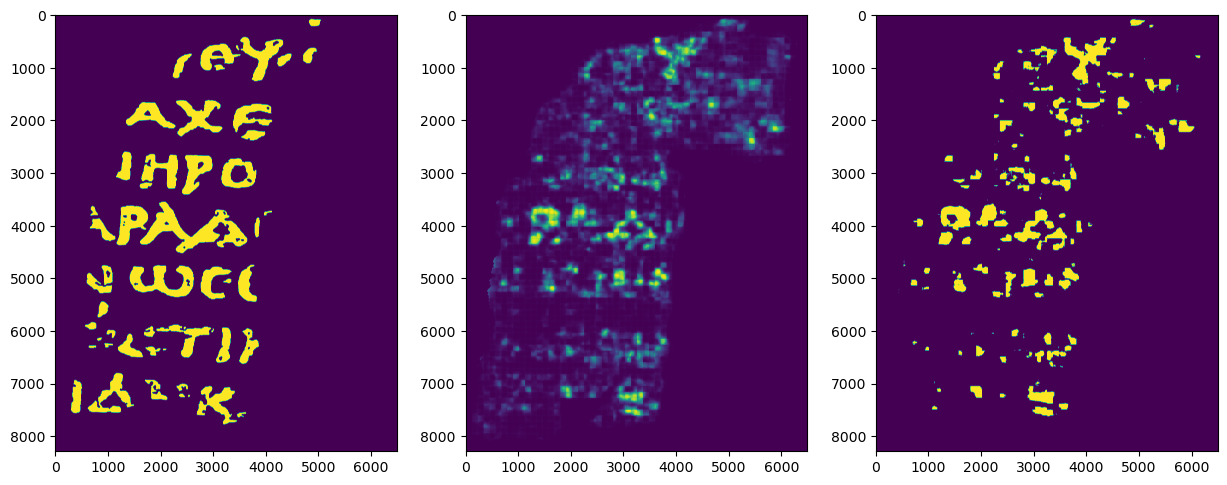

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([4.1785688e+07, 4.1174120e+06, 2.0938190e+06, 1.2974600e+06,
        8.9248000e+05, 6.5566400e+05, 5.3152600e+05, 4.4008900e+05,
        3.5112100e+05, 2.7898400e+05, 2.2861100e+05, 2.1635900e+05,
        1.8306300e+05, 1.5503900e+05, 1.3167700e+05, 1.2441800e+05,
        1.1646000e+05, 1.1011100e+05, 9.0204000e+04, 3.8663000e+04]),
 array([4.78628252e-06, 4.84573058e-02, 9.69098252e-02, 1.45362345e-01,
        1.93814864e-01, 2.42267384e-01, 2.90719903e-01, 3.39172423e-01,
        3.87624942e-01, 4.36077462e-01, 4.84529981e-01, 5.32982501e-01,
        5.81435020e-01, 6.29887539e-01, 6.78340059e-01, 7.26792578e-01,
        7.75245098e-01, 8.23697617e-01, 8.72150137e-01, 9.20602656e-01,
        9.69055176e-01]),
 <BarContainer object of 20 artists>)

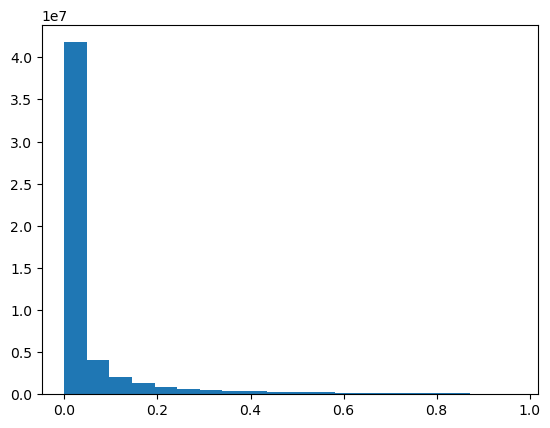

In [35]:
plt.hist(mask_pred.flatten(), bins=20)